In [183]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import Callback
import numpy as np
import fasttext.util
import pickle
from transformers import BertTokenizer, TFBertModel

In [184]:
train_data = json.load(open('../Dataset/BIO_Tagged/ATE_train.json'))
val_data = json.load(open('../Dataset/BIO_Tagged/ATE_val.json'))
test_data = json.load(open('../Dataset/BIO_Tagged/ATE_test.json'))

In [185]:
word2vec = pickle.load(open('Word Embeddings/word2vec.pkl', 'rb'))
glove = pickle.load(open('Word Embeddings/glove.pkl', 'rb'))
# Add another embedding here

In [186]:
def prepareData(train_data, embedding_type):
    X, Y = [], []
    for data in train_data:
        X.append(train_data[data]['text'].split())
        Y.append(train_data[data]['labels'])
        
    num_words = len(set([word.lower() for sentence in X for word in sentence]))       
    word_tokenizer = Tokenizer()                      
    word_tokenizer.fit_on_texts(X)                    
    X_encoded = word_tokenizer.texts_to_sequences(X)

    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(Y)
    Y_encoded = tag_tokenizer.texts_to_sequences(Y)

    max_seq_length = 50

    X_padded = pad_sequences(X_encoded, maxlen=max_seq_length, padding="pre", truncating="post")
    Y_padded = pad_sequences(Y_encoded, maxlen=max_seq_length, padding="pre", truncating="post")

    X, Y = X_padded, Y_padded    

    embedding_matrix = np.zeros((num_words+1, 300))
    
    word2id = word_tokenizer.word_index
    for word, index in word2id.items():
        try:
            embedding_matrix[index, :] = embedding_type[word]
        except KeyError:
            pass    

    Y = to_categorical(Y)

    return X, Y, embedding_matrix, word_tokenizer, tag_tokenizer

In [187]:
data = {}
data['word2vec'] = {}
data['glove'] = {}

data['word2vec']['X_train'], data['word2vec']['Y_train'], data['word2vec']['train_embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, word2vec)
data['word2vec']['X_val'], data['word2vec']['Y_val'], data['word2vec']['val_embedding_matrix'], _, _ = prepareData(val_data, word2vec)
data['word2vec']['X_test'], data['word2vec']['Y_test'], data['word2vec']['test_embedding_matrix'], _, _ = prepareData(test_data, word2vec)

data['glove']['X_train'], data['glove']['Y_train'], data['glove']['train_embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, glove)
data['glove']['X_val'], data['glove']['Y_val'], data['glove']['val_embedding_matrix'],  _, _ = prepareData(val_data, glove)
data['glove']['X_test'], data['glove']['Y_test'], data['glove']['test_embedding_matrix'],  _, _ = prepareData(test_data, glove)

In [188]:
class MacroF1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = np.argmax(self.model.predict(self.train_data[0]), axis=-1)
        train_true = np.argmax(self.train_data[1], axis=-1)
        train_f1 = f1_score(train_true.flatten(), train_pred.flatten(), average='macro')

        val_pred = np.argmax(self.model.predict(self.val_data[0]), axis=-1)
        val_true = np.argmax(self.val_data[1], axis=-1)
        val_f1 = f1_score(val_true.flatten(), val_pred.flatten(), average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        print(f'Epoch {epoch + 1} - Train Macro-F1: {train_f1:.4f} - Val Macro-F1: {val_f1:.4f}')


## VANILLA RNN

In [189]:
def trainRNN(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    rnn_model.add(SimpleRNN(64, return_sequences=True))

    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    rnn_model.save(f'Models/t2_rnn_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 2ms/step
Epoch 1 - Train Macro-F1: 0.4443 - Val Macro-F1: 0.4418
8/8 [==============================] - 1s 76ms/step - loss: 1.0368 - acc: 0.8050 - val_loss: 0.5877 - val_acc: 0.8746
Epoch 2/10
7/7 [==============================] - 0s 3ms/step
Epoch 2 - Train Macro-F1: 0.4587 - Val Macro-F1: 0.4580
8/8 [==============================] - 0s 52ms/step - loss: 0.4774 - acc: 0.8893 - val_loss: 0.4008 - val_acc: 0.9021
Epoch 3/10
7/7 [==============================] - 0s 3ms/step
Epoch 3 - Train Macro-F1: 0.4780 - Val Macro-F1: 0.4592
8/8 [==============================] - 0s 53ms/step - loss: 0.3410 - acc: 0.9045 - val_loss: 0.3337 - val_acc: 0.9010
Epoch 4/10
7/7 [==============================] - 0s 3ms/step
Epoch 4 - Train Macro-F1: 0.5422 - Val Macro-F1: 0.4801
8/8 [==============================] - 0s 54ms/step - loss: 0.2755 - acc: 0.9126 - val_loss: 0.2983 - val_acc: 0.9123
Epoch 5/10
7/7 [==============================] - 0s 3ms

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


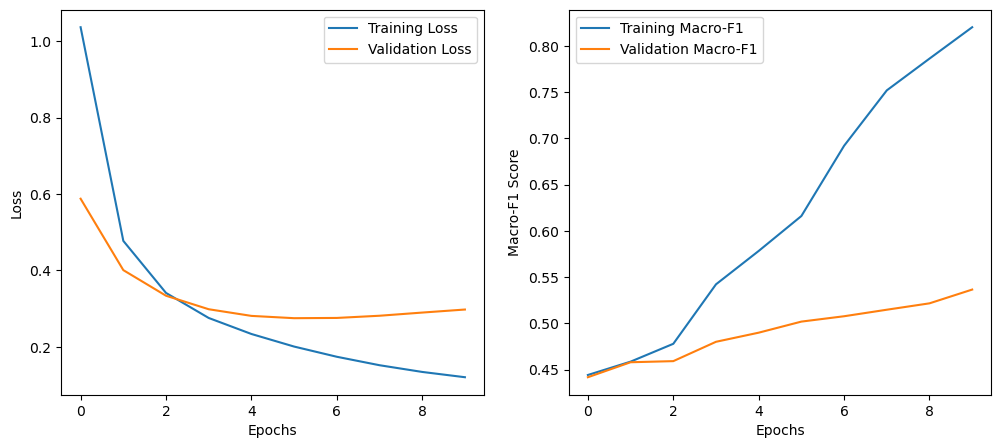

In [190]:
trainRNN('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 3ms/step
Epoch 1 - Train Macro-F1: 0.5177 - Val Macro-F1: 0.4811
8/8 [==============================] - 1s 78ms/step - loss: 1.0789 - acc: 0.8644 - val_loss: 0.6538 - val_acc: 0.9123
Epoch 2/10
7/7 [==============================] - 0s 2ms/step
Epoch 2 - Train Macro-F1: 0.5576 - Val Macro-F1: 0.4892
8/8 [==============================] - 0s 45ms/step - loss: 0.4693 - acc: 0.9158 - val_loss: 0.3642 - val_acc: 0.9079
Epoch 3/10
7/7 [==============================] - 0s 3ms/step
Epoch 3 - Train Macro-F1: 0.6122 - Val Macro-F1: 0.5186
8/8 [==============================] - 0s 44ms/step - loss: 0.2769 - acc: 0.9232 - val_loss: 0.3007 - val_acc: 0.9040
Epoch 4/10
7/7 [==============================] - 0s 3ms/step
Epoch 4 - Train Macro-F1: 0.6314 - Val Macro-F1: 0.5202
8/8 [==============================] - 0s 44ms/step - loss: 0.2183 - acc: 0.9333 - val_loss: 0.2782 - val_acc: 0.9106
Epoch 5/10
7/7 [==============================] - 0s 3ms

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


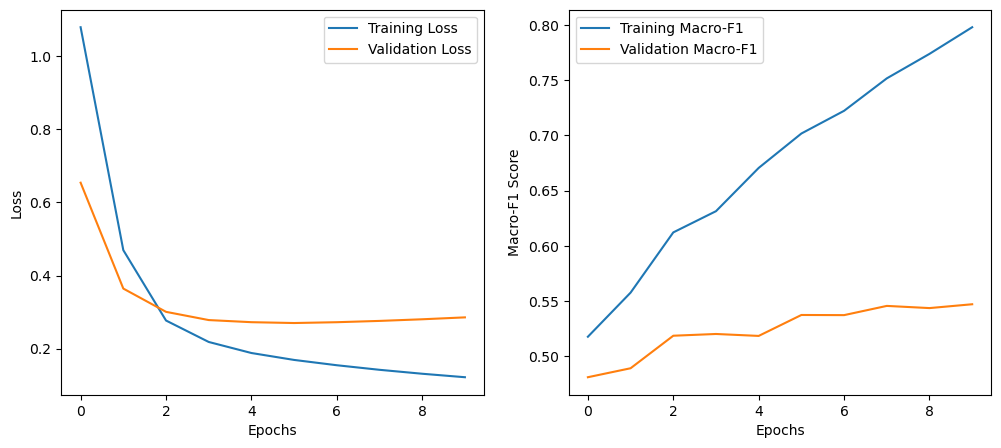

In [191]:
trainRNN('glove')

## LSTM

In [192]:
def trainLSTM(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    lstm_model.add(LSTM(64, return_sequences=True))

    lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    lstm_model.save(f'Models/t2_lstm_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 6ms/step
Epoch 1 - Train Macro-F1: 0.4630 - Val Macro-F1: 0.4625
8/8 [==============================] - 2s 178ms/step - loss: 1.2685 - acc: 0.8545 - val_loss: 1.0379 - val_acc: 0.9095
Epoch 2/10
7/7 [==============================] - 0s 6ms/step
Epoch 2 - Train Macro-F1: 0.4467 - Val Macro-F1: 0.4454
8/8 [==============================] - 1s 85ms/step - loss: 0.8605 - acc: 0.9021 - val_loss: 0.5809 - val_acc: 0.8806
Epoch 3/10
7/7 [==============================] - 0s 7ms/step
Epoch 3 - Train Macro-F1: 0.4588 - Val Macro-F1: 0.4585
8/8 [==============================] - 1s 82ms/step - loss: 0.5055 - acc: 0.8747 - val_loss: 0.3979 - val_acc: 0.9027
Epoch 4/10
7/7 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.4596 - Val Macro-F1: 0.4589
8/8 [==============================] - 1s 85ms/step - loss: 0.3612 - acc: 0.9072 - val_loss: 0.3302 - val_acc: 0.9036
Epoch 5/10
7/7 [==============================] - 0s 6m

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


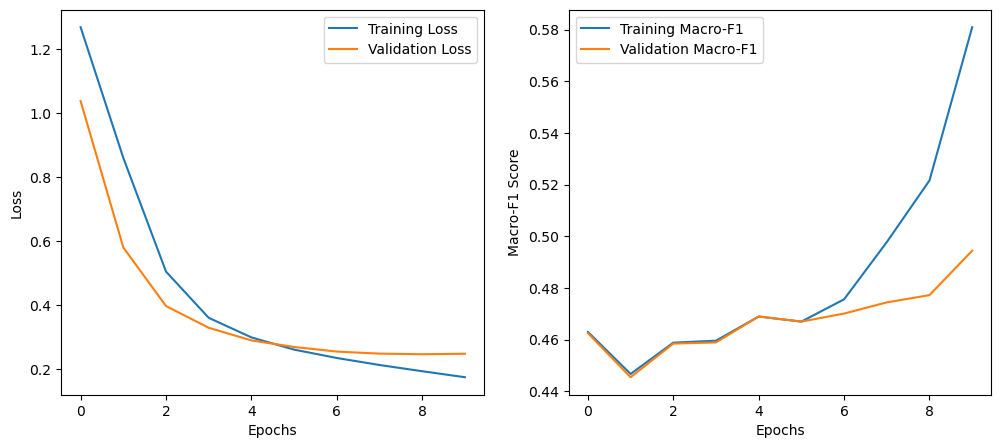

In [193]:
trainLSTM('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 8ms/step
Epoch 1 - Train Macro-F1: 0.4723 - Val Macro-F1: 0.4717
8/8 [==============================] - 2s 142ms/step - loss: 1.2606 - acc: 0.8210 - val_loss: 0.9745 - val_acc: 0.9247
Epoch 2/10
7/7 [==============================] - 0s 8ms/step
Epoch 2 - Train Macro-F1: 0.4618 - Val Macro-F1: 0.4620
8/8 [==============================] - 1s 98ms/step - loss: 0.8446 - acc: 0.9214 - val_loss: 0.6014 - val_acc: 0.9086
Epoch 3/10
7/7 [==============================] - 0s 8ms/step
Epoch 3 - Train Macro-F1: 0.4506 - Val Macro-F1: 0.4495
8/8 [==============================] - 1s 116ms/step - loss: 0.4876 - acc: 0.8939 - val_loss: 0.4167 - val_acc: 0.8870
Epoch 4/10
7/7 [==============================] - 0s 9ms/step
Epoch 4 - Train Macro-F1: 0.4649 - Val Macro-F1: 0.4651
8/8 [==============================] - 1s 105ms/step - loss: 0.3555 - acc: 0.8962 - val_loss: 0.3156 - val_acc: 0.9135
Epoch 5/10
7/7 [==============================] - 0s 

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


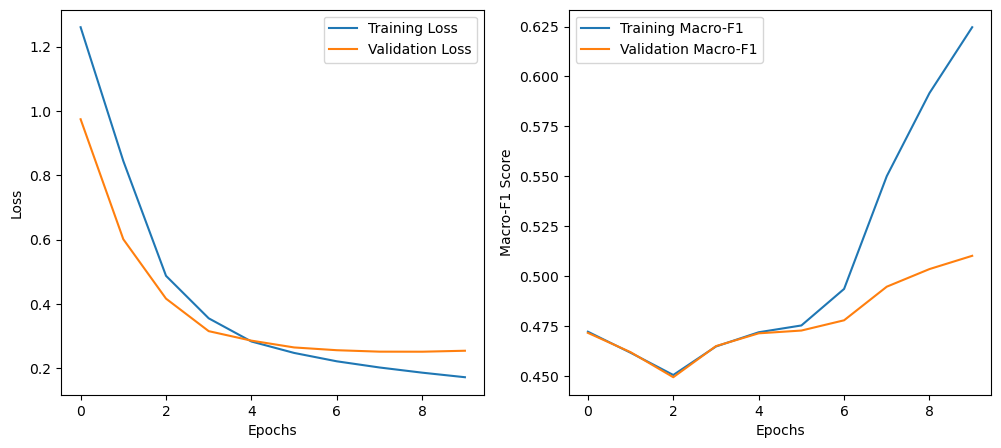

In [194]:
trainLSTM('glove')

## GRU

In [195]:
def trainGRU(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    gru_model.add(GRU(64, return_sequences=True))

    gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    gru_model.save(f'Models/t2_gru_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4729 - Val Macro-F1: 0.4721
8/8 [==============================] - 2s 131ms/step - loss: 1.2486 - acc: 0.8918 - val_loss: 1.0381 - val_acc: 0.9254
Epoch 2/10
7/7 [==============================] - 0s 5ms/step
Epoch 2 - Train Macro-F1: 0.4707 - Val Macro-F1: 0.4708
8/8 [==============================] - 1s 80ms/step - loss: 0.8779 - acc: 0.9227 - val_loss: 0.6203 - val_acc: 0.9231
Epoch 3/10
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.4595 - Val Macro-F1: 0.4590
8/8 [==============================] - 1s 78ms/step - loss: 0.4541 - acc: 0.9142 - val_loss: 0.3379 - val_acc: 0.9034
Epoch 4/10
7/7 [==============================] - 0s 6ms/step
Epoch 4 - Train Macro-F1: 0.4636 - Val Macro-F1: 0.4618
8/8 [==============================] - 1s 80ms/step - loss: 0.2905 - acc: 0.9015 - val_loss: 0.2910 - val_acc: 0.9082
Epoch 5/10
7/7 [==============================] - 0s 5m

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


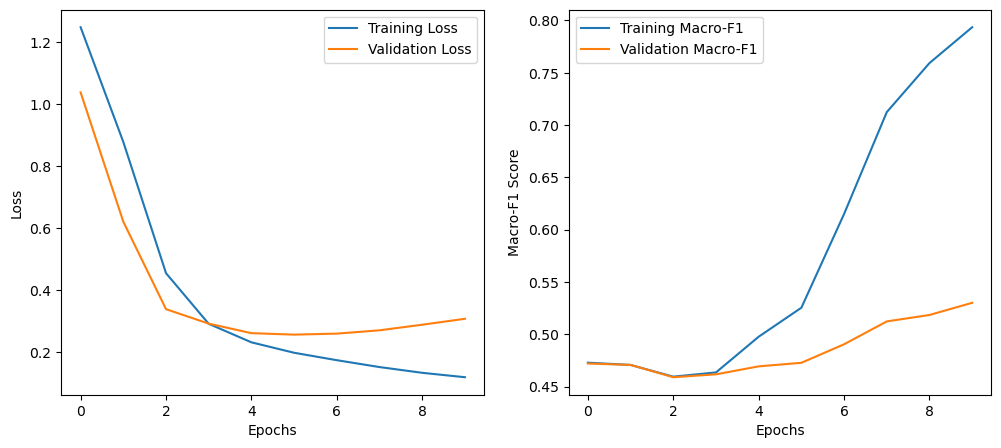

In [196]:
trainGRU('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4784 - Val Macro-F1: 0.4730
8/8 [==============================] - 2s 131ms/step - loss: 1.2292 - acc: 0.8426 - val_loss: 0.9802 - val_acc: 0.9253
Epoch 2/10
7/7 [==============================] - 0s 6ms/step
Epoch 2 - Train Macro-F1: 0.4800 - Val Macro-F1: 0.4746
8/8 [==============================] - 1s 82ms/step - loss: 0.8465 - acc: 0.9239 - val_loss: 0.6698 - val_acc: 0.9253
Epoch 3/10
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.5159 - Val Macro-F1: 0.4823
8/8 [==============================] - 1s 85ms/step - loss: 0.4697 - acc: 0.9239 - val_loss: 0.3206 - val_acc: 0.9114
Epoch 4/10
7/7 [==============================] - 0s 10ms/step
Epoch 4 - Train Macro-F1: 0.5824 - Val Macro-F1: 0.5043
8/8 [==============================] - 1s 145ms/step - loss: 0.2518 - acc: 0.9179 - val_loss: 0.2887 - val_acc: 0.8998
Epoch 5/10
7/7 [==============================] - 0s 

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


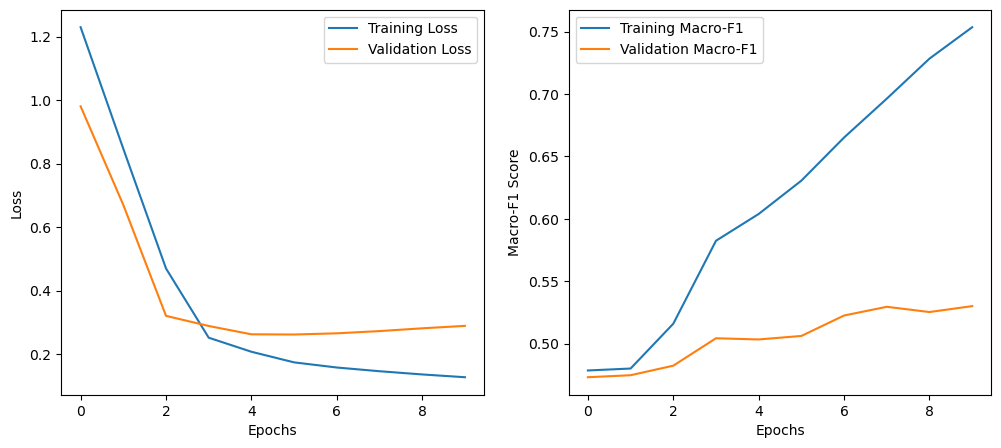

In [197]:
trainGRU('glove')